In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_wine = pd.read_csv('C:/Users/柠檬有点萌/Desktop/machine_learning/wine.data', header=None)

In [2]:
#按7：3分裂成独立的训练集和测试集
from sklearn.model_selection import train_test_split
X, Y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
#标准化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[Y_train==label], axis=0))
    print('MV %s:%s\n' %(label, mean_vecs[label-1]))

MV 1:[ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2:[-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3:[ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [5]:
#计算类内散布矩阵S_W
d = 13   #特征值数量
#返回一个用0填充的给定形状数组
s_w = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[Y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    s_w += class_scatter
print('Within-class scatter matrix: %sx%s' % (s_w.shape[0], s_w.shape[1]))

Within-class scatter matrix: 13x13


In [6]:
#计算类间散布矩阵S_B
mean_overall = np.mean(X_train_std, axis=0)
d = 13
s_b = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[Y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    s_b += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (s_b.shape[0], s_b.shape[1]))

Between-class scatter matrix: 13x13


In [7]:
eigen_vals, eigen_vecs = \
    np.linalg.eig(np.linalg.inv(s_w).dot(s_b))
#构建（特征值，特征向量）的元组列表
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
#将元组降序排列
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

8.262493673957486
4.225659486916688
1.0528816291206889e-15
8.881784197001252e-16
4.899094033918741e-16
4.899094033918741e-16
4.459087001584629e-16
3.7475856725614787e-16
3.7408464699083565e-16
3.7408464699083565e-16
2.819199765804213e-16
8.058442121308179e-17
4.534449124261265e-17


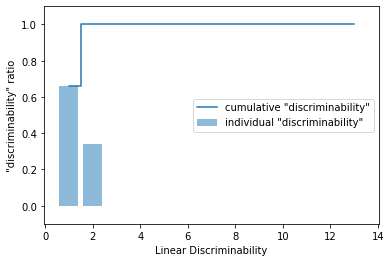

In [10]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
#计算出解释方差和
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminability')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.show()

In [11]:
#创建转换矩阵W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


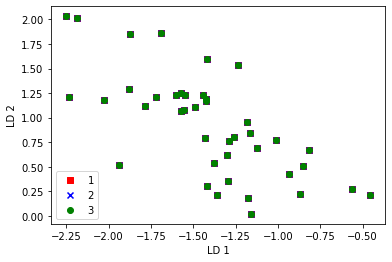

In [13]:
X_train_lda = X_train_std.dot(w)
colors = ['red','blue','green']
markers = ['s','x','o']
for l,c,m in zip(np.unique(Y_train), colors, markers):
    plt.scatter(X_train_lda[Y_train==1, 0], X_train_lda[Y_train==1, 1] * (-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

In [14]:
#使用scikit-learn来实现LDA

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,Y,classifier,resolution=0.02):
    #定义颜色和标记，创建色度图
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(Y))])

    #画出目标界面
    x1_min,x1_max = X[:,0].min()-1 , X[:,0].max()+1  #横坐标最大值和最小值
    x2_min,x2_max = X[:,1].min()-1 , X[:,1].max()+1  #纵坐标最大值和最小值
    #绘制网格图，利用矩阵
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    #ravel函数将矩阵变为一维数组
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    #填充等高线
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    for idx,cl in enumerate(np.unique(Y)):
        #X,Y均为矩阵，把点画出来
        plt.scatter(x=X[Y == cl,0] , y=X[Y == cl,1] , alpha = 0.8 , c = colors[idx] , marker = markers[idx] , label = cl , edgecolor = 'black')


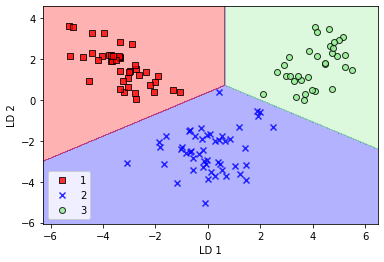

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std,Y_train)
lr = LogisticRegression()
lr = lr.fit(X_train_lda, Y_train)
plot_decision_regions(X_train_lda, Y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

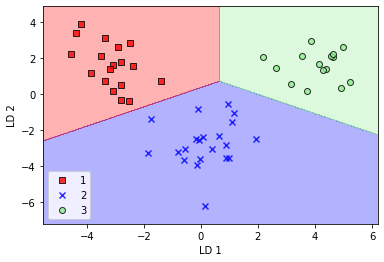

In [17]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, Y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()